In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time

In [4]:
path = '../PostBornEma/'
sys.path.append("../scripts/") 
from lab import *


# Vanessa's implementations of $G^{ab}$s

### 1) $ G_l^{\phi\psi}(\chi_{max}, \chi_2) = \int_0^{\chi_{max}} \mathrm{d} \chi_1 W(\chi_1, \chi_{max}) C_l^{\psi\psi}(\chi_1,\chi_2)$ 
$= \mathcal{A}^2 \frac{1}{2\pi^2} \sum_n \int_0^1  \chi_2^{(1-\nu_n)} [1+z(\chi_2)] D(\chi_2) I^0_l (\nu_n,t)\left[W(t\chi_2,\chi_{max}) D(\chi_2 t) [1+z(\chi_2 t)] + W(1/t \chi_2,\chi_{max}) t^{\nu_n-2}D(\chi_2/t)[1+z(\chi_2/t)]\right]$

needs to be evaluated for varying $\chi_{max}$ and $\chi_2$ (this appears in Eq. 4.2).

replacing $\chi_2$ by $r\chi_{max}$ allows doing basically the same as before, just without summing over $r$,
so that the ouput for fixed $\chi_{max}$ has shape of $r$.
Then we only need one loop over $\chi_{max}$.

In [129]:
def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi)
chi2_max = chi_cmb
chi1_max = chi_cmb

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
# inflate by one dimensions (nu_n)
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


Cl = np.zeros((len(t_),len(ell_),len(t_)))

begin=time.time()

for jj, chi1_max in enumerate((t_*chi_cmb)):
    if jj%10==0:
        print(jj)

    chi1fac0 = (D_chi(r2d*chi2_max)*(1.+z_chi(r2d*chi2_max)))
    chi1fac0 = chi1fac0 *(r2d*chi2_max)**(1-nu_n_.reshape(1, 1, -1))

    # no lensing kernel, because no lensing integration of chi_2
    chi2fac00 = (D_chi(r2d*t2d*chi2_max)*(1+z_chi(r2d*t2d*chi2_max))*lensing_kernel(r2d*t2d*chi2_max, chi1_max))

    chi2fac01 = (D_chi(r2d*1./t2d*chi2_max)*(1+z_chi(r2d*1./t2d*chi2_max))*lensing_kernel(r2d*1./t2d*chi2_max, chi1_max))

    chi2fac01 = chi2fac01 * t2d**(nu_n_.reshape(1, 1, -1)-2)
    chi2fac0  = chi2fac00 + chi2fac01

    chifacs   = w12*chi1fac0* chi2fac0

    result = np.zeros((len(ell_),len(t_)))
    lmax   = ell_.size
    for ii  in range(ell_.size):        
        result[ii] = np.sum(chifacs*I0_ltrc[ii], axis=(0,2)) #not summing over r

    Cl[jj] = result*1./np.pi**2/2.*prefac**2 #divide by to for Gauss quad and times two for phi cancel
# swap axes to have cl_phipsi_l(chi_max,chi)
Cl = np.swapaxes(Cl,0,1)
print('Time taken = ', time.time()-begin)

np.save('../G_matrices/clphipsi',Cl)

0


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
Time taken =  149.98093485832214


to get $C_l^{\phi\phi}(\chi_1,\chi_2)$ we only need to do one more looped integral:

$C_l^{\phi\phi}(\chi_{max1},\chi_{max2})= \int_0^{\chi_{max2}} \mathrm{d}\chi_2  W(\chi_2,\chi_{max2}) C_l^{\phi\psi}(\chi_{max1},\chi_2)$

with loop over $\chi_{max2}$

with parametrization by $r$ and Gaussian quadrature this becomes

$C_l^{\phi\phi}(\chi_{max1},\chi_{max2})=\chi_{max2} \int_0^{1} \mathrm{d} r  W(\chi_{max2} r ,\chi_{max2}) C_l^{\phi\psi}(\chi_{max1},\chi_{max2} r)= \chi_{max2} / 2 \sum_{r_{i}} w_i W(\chi_{max2} r_{i} ,\chi_{max2}) C_l^{\phi\psi}(\chi_{max1},\chi_{max2} r_{i})$

In [24]:
#again times 2 and dive by two cancel to leave only this
result = np.zeros((len(t_),len(ell_),len(t_)))

for jj, chimax in enumerate(t_*chi_cmb):
    test   = np.zeros((len(ell_),len(t_)))
    for ii  in range(ell_.size): 
        test[ii] = chimax*np.sum(Cl[ii,:,:]*lensing_kernel(t_*chimax, chimax)*w1, axis=-1)
    result[jj] = test
result = np.swapaxes(result,0,1)

np.save('../G_matrices/clphiphi',result)

(2, 2000)

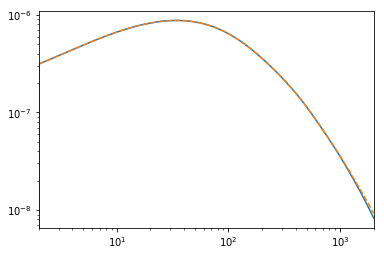

In [25]:
#lets check if we get the correct result when we look at the last entry where chi_max=chi_cmb

ll,clpp = np.load('../output/clpp_class_no_limber.npy')
clphiphi = result[:,-1,-1]
plt.loglog(ll,(ll*(ll+1.))**2*clpp)
plt.loglog(ell_,(ell_*(ell_+1))**2*clphiphi,ls='--')
plt.loglog()
plt.xlim(2,2000)
# perfect :)

In [121]:
#loading Chirags result and compare
clphiphi2 = np.zeros((len(t_),len(ell_),len(t_)))
path = '../output/clphiphi/'
for ii in range(len(t_)):
    clphiphi2[ii] = np.loadtxt(path+'%d.txt'%ii)[:,1:]
clphiphi2=np.swapaxes(clphiphi2,0,1)

#results agree with Chirag
print(np.allclose(clphiphi2,result,atol=1e-9))

False


[[ 7.22241879e+02  7.88970077e+03  2.07835211e+04 ...  1.39134467e+05
   1.39134467e+05  1.39137410e+05]
 [ 1.49559991e+03  2.69426552e+04  8.70478180e+04 ...  7.00889085e+05
   7.00916998e+05  7.00916998e+05]
 [ 1.60124135e+03  3.53767250e+04  1.41244448e+05 ...  1.57422041e+06
   1.57422041e+06  1.57422041e+06]
 ...
 [-9.99956906e-01 -9.98864133e-01 -9.93717144e-01 ...  2.94225773e+00
   2.94334434e+00  2.94384237e+00]
 [-9.99957099e-01 -9.98869311e-01 -9.93745789e-01 ...  2.92536578e+00
   2.92635730e+00  2.92694319e+00]
 [-9.99957208e-01 -9.98872192e-01 -9.93761724e-01 ...  2.91590392e+00
   2.91689291e+00  2.91743236e+00]]
[[-1.00005735 -0.99990235 -0.99988538 ... -0.99987375 -0.99987375
  -0.99987375]
 [-0.99999283 -0.30837296  0.6418227  ...  1.30002803  1.30002803
   1.30002803]
 [-1.00002007 -0.33544335  8.32584444 ... 26.37301866 26.37301866
  26.37301866]
 ...
 [-1.         -1.         -0.99999999 ... -0.98002914 -0.98001941
  -0.98001333]
 [-1.         -1.         -0.999999

### tesing gaussian quadrature with simple integral test
$\int_0^1 \mathrm{d} x x^2 = 1/2 \sum_i w_i t_i^2 = 1/3 $

In [49]:
0.5*np.sum(w1*t_**2)

0.33333333387229197

## 2) $ G_l^{\phi\delta}(\chi_{max}, \chi_2) = \int_0^{\chi_{max}} \mathrm{d} \chi_1 W(\chi_1, \chi_{max}) C_l^{\psi\delta}(\chi_1,\chi_2)$ 
$= \mathcal{A} \frac{2}{2\pi^2} \sum_n \int_0^1  \chi_2^{(1-\nu_n)} D(\chi_2) I^2_l (\nu_n,t)\left[W(t\chi_2,\chi_{max}) D(\chi_2 t) [1+z(\chi_2 t)] + W(1/t \chi_2,\chi_{max}) t^{(2+\nu_n)-2}D(\chi_2/t)[1+z(\chi_2/t)]\right]$

In [27]:
#define different redshift kernels (at some point load this)

# 1) general kernel if dNdz is Gaussian
def Gauss_redshift(z0,sigma_z):
    def z_kernel(z):
        return 1./np.sqrt(2.*np.pi)/sigma_z*np.exp(-(z-z0)**2/2./sigma_z**2)
    return z_kernel

def gal_kernel(z_kernel,ximax=5):
    def chi_kernel(xi):
        return z_kernel(z_chi(xi))*dz_dchi(xi)
    return chi_kernel


# 2) prospective LSST kernels
def dNdz_LSST(bin_num,dn_filename = '../LSSTdndzs/dndz_LSST_i27_SN5_3y'):
    if bin_num is "all":
        zbin, nbin = np.load(dn_filename+'tot_extrapolated.npy',encoding='latin1')
        norm                = np.trapz(nbin,zbin)
        mbin                = 'None'
    else:
        bins,big_grid,res   = np.load(dn_filename+'_extrapolated.npy',encoding='latin1')
        mbin                = bins[bin_num]
        zbin                = big_grid
        nbin                = res[bin_num]
        norm                = np.trapz(nbin,zbin)
    dndz                = interp1d(zbin, nbin/norm, kind='linear',bounds_error=False,fill_value=0.)
    print('using z-bin', mbin, 'norm', norm)
    return dndz



def gal_clus(dNdz,b,bin_num):
    """
    dNdz: function returning function dndz for gicen bin number 
    b: function returning bias as function of z 
    bin_num: bin_number (either 'all' or 0-5)
    """
    p_z=dNdz(bin_num)
    def kernel(x):
        z = z_chi(x)
        return b(z)*p_z(z)*dz_dchi(z)

    return kernel

def simple_bias(z):
    return (1.+z)

def constant_bias(z,b=1.):
    return b

In [117]:
r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
#nu axis
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

# chimax and kernels
chimax1   = chi_cmb

#can be sth smaller if we work with redshift bins
chimax2   = chi_z(10.)

n = 2

Cl = np.zeros((len(t_),len(ell_),len(t_)))

begin=time.time()

for jj, chi1max in enumerate((t_*chi_cmb)):
    if jj%10==0:
        print(jj)
        
    chi1fac0 = D_chi(r2d*chimax2)
    chi1fac0 = chi1fac0 *(r2d*chimax2)**(1-(n+nu_n_.reshape(1, 1, -1)))

    chi2fac00 = (lensing_kernel(t2d*r2d*chimax2,chimax1)*D_chi(r2d*t2d*chimax2)*(1+z_chi(r2d*t2d*chimax2)))
    chi2fac01 = (lensing_kernel(1./t2d*r2d*chimax2,chimax1)*D_chi(r2d/t2d*chimax2)*(1+z_chi(r2d*1./t2d*chimax2)))
    chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
    chi2fac0  = chi2fac00 + chi2fac01

    chifacs = w12*chi1fac0* chi2fac0

    result=np.zeros((len(ell_),len(t_)))
    lmax = ell_.size
    for ii  in range(ell_.size):        
        result[ii] = np.sum(chifacs*I2_ltrc[ii],axis=(0,2))
    
    Cl[jj] = result*1./np.pi**2/2.*prefac/2.
#Cl_pg = chimax * result*1./np.pi**2/2.*prefac/4.*2

Cl = np.swapaxes(Cl,0,1)
print('Time taken = ', time.time()-begin)

chi1,chi2 = np.meshgrid((t_*chi_cmb, t_*chimax2))

np.save('../G_matrices/clphidelta',[Cl,chi1,chi2])

0


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
Time taken =  163.11217403411865


In [118]:
# check if I can recover Clkg:
result = np.zeros((len(t_),len(ell_),len(t_)))

mean = 3.
width = 0.5
galaxy_kernel = gal_kernel(Gauss_redshift(mean,width))

for jj, chimax in enumerate(t_*chimax2):
    test   = np.zeros((len(ell_),len(t_)))
    for ii  in range(ell_.size): 
        test[ii] = chimax*np.sum(Cl[ii,:,:]*galaxy_kernel(t_*chimax)*w1, axis=-1)
    result[jj] = test
result = np.swapaxes(result,0,1)
clphig = result

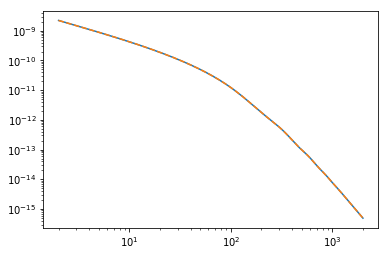

In [119]:
# compare result to saved value
ell_,Cl_pg = np.load('../output/Clpg_mean%d_width%0.e.npy'%(mean,width))
plt.loglog(ell_,Cl_pg)
plt.loglog(ell_,clphig[:,-1,-1],ls='--')

#fits! :)

### 3) $C_L^{\psi\psi}(\chi1,\chi2)$

In [54]:
def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi)
chi2_max = chi_cmb
chi1_max = chi_cmb

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
# inflate by one dimensions (nu_n)
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

Cl = np.zeros((len(ell_),len(t_),len(t_)))

begin=time.time()

chi1fac0 = (D_chi(r2d*chi2_max)*(1.+z_chi(r2d*chi2_max)))
chi1fac0 = chi1fac0 *(r2d*chi2_max)**(1-nu_n_.reshape(1, 1, -1))

# no lensing kernel, because no lensing integration of chi_2
chi2fac00 = (D_chi(r2d*t2d*chi2_max)*(1+z_chi(r2d*t2d*chi2_max)))
chi2fac01 = (D_chi(r2d*1./t2d*chi2_max)*(1+z_chi(r2d*1./t2d*chi2_max)))
chi2fac01 = chi2fac01 * t2d**(nu_n_.reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01

chifacs   = chi1fac0* chi2fac0


for ii  in range(ell_.size):        
    Cl[ii] = np.sum(chifacs*I0_ltrc[ii], axis=(2)) #not summing over r or t

Cl = Cl*1./np.pi**2/2.*prefac**2 #divide by to for Gauss quad and times two for phi cancel
# swap axes to have cl_phipsi_l(chi_max,chi)

print('Time taken = ', time.time()-begin)

np.save('../G_matrices/clpsipsi',Cl)

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  1.3762388229370117
